<a href="https://colab.research.google.com/github/caiocesarcosta/AndroidTVappTutorial/blob/master/matrix_confusion_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 100 images belonging to 2 classes.
Imagens de treino: 602
Imagens de validação: 100
Classes: {'cats': 0, 'dogs': 1}
Class names: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5172 - loss: 0.8051
Epoch 1/1 - Precisão de Treino: 0.5070, Perda de Treino: 0.7493, Precisão de Validação: 0.5833, Perda de Validação: 0.6895
18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - accuracy: 0.5167 - loss: 0.8022 - val_accuracy: 0.5833 - val_loss: 0.6895

Training History:
  Época 1: Precisão de Treino = 0.5070, Perda de Treino = 0.7493, Precisão de Validação = 0.5833, Perda de Validação = 0.6895
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step


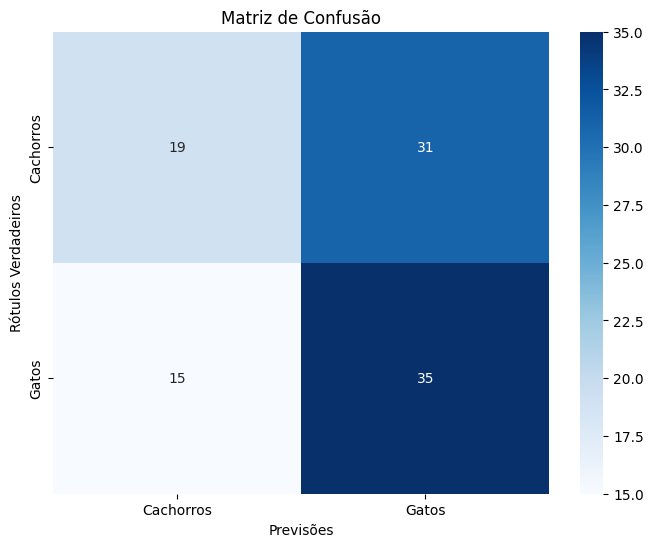

                                  0
Acurácia                   0.540000
Precisão (Cachorros)       0.558824
Sensibilidade (Cachorros)  0.380000
F1-Score (Cachorros)       0.452381
Precisão (Gatos)           0.530303
Sensibilidade (Gatos)      0.700000
F1-Score (Gatos)           0.603448
Erro                       0.460000
Area Under the ROC Curve: 0.50


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import shutil
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd # Importa o pandas com o alias 'pd'
# Importa as funções roc_curve e auc explicitamente
from sklearn.metrics import roc_curve, auc

# Classe MyCallback
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}/{self.epochs} - Precisão de Treino: {logs['accuracy']:.4f}, Perda de Treino: {logs['loss']:.4f}, Precisão de Validação: {logs['val_accuracy']:.4f}, Perda de Validação: {logs['val_loss']:.4f}")

# Classe Principal
class TransferLearningBinary:
    def __init__(self, train_data_dir, validation_data_dir, nb_train_samples, nb_validation_samples, epochs, batch_size):
        self.__train_data_dir = train_data_dir
        self.__validation_data_dir = validation_data_dir
        self.__nb_train_samples = nb_train_samples
        self.__nb_validation_samples = nb_validation_samples
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__img_width, self.__img_height = 150, 150
        self.__model = self._getModelSequential()
        self._compileModel()

    def _validateImage(self):
        drive.mount('/content/drive')
        try:
            # Vamos tentar ler um arquivo de cada classe para garantir que elas estão presentes
            cat_path = f'{self.__train_data_dir}/cats/0.jpg'
            dog_path = f'{self.__train_data_dir}/dogs/0.jpg'

            # Verifica se o arquivo existe, caso não, o programa é interrompido
            if not os.path.exists(cat_path):
               print(f"ERRO: Imagem de teste não encontrada: {cat_path}, Verifique o caminho e se há imagens nas pastas train/cats")
               exit()
            if not os.path.exists(dog_path):
               print(f"ERRO: Imagem de teste não encontrada: {dog_path}, Verifique o caminho e se há imagens nas pastas train/dogs")
               exit()

            # leitura da imagem de exemplo, que será utilizada para obter as dimensões
            img = image.load_img(cat_path)
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            input_shape = (self.__img_width, self.__img_height, 3) if tf.keras.backend.image_data_format() == 'channels_last' else (3, self.__img_width, self.__img_height)
            return input_shape
        except Exception as e:
            print(f"ERRO ao carregar imagem: {e}")
            exit()

    def _getModelSequential(self):
        input_shape = self._validateImage()
        return Sequential([
            Conv2D(32, (3, 3), input_shape=input_shape),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, (3, 3)), # Adicionando mais uma camada conv
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(128, (3, 3)), # Adicionando mais uma camada conv
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(128), # Aumentando o tamanho da camada densa
            Activation('relu'),
            Dropout(0.5),
            Dense(1),
            Activation('sigmoid')
        ])

    def _compileModel(self):
        self.__model.compile(loss='binary_crossentropy',
                              optimizer='adam', # Adicionando Adam como otimizador
                              metrics=['accuracy'])

    def _initTrain(self):
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

        test_datagen = ImageDataGenerator(rescale=1. / 255)

        self.__train_generator = train_datagen.flow_from_directory(
            self.__train_data_dir,
            target_size=(self.__img_width, self.__img_height),
            batch_size=self.__batch_size,
            class_mode='binary')

        self.__validation_generator = test_datagen.flow_from_directory(
            self.__validation_data_dir,
            target_size=(self.__img_width, self.__img_height),
            batch_size=self.__batch_size,
            class_mode='binary')

        print(f"Imagens de treino: {len(self.__train_generator.filenames)}")
        print(f"Imagens de validação: {len(self.__validation_generator.filenames)}")
        print(f"Classes: {self.__train_generator.class_indices}")
        print(f"Class names: {self.__train_generator.classes}")

        # Print batch sample for debugging
        for i in range(min(3, len(self.__train_generator))): # Limit to 3 batches
            batch_x, batch_y = self.__train_generator[i]
            print(f"Training Batch {i+1} - batch_x shape: {batch_x.shape}, batch_y shape: {batch_y.shape}, classes: {batch_y}")
        for i in range(min(3, len(self.__validation_generator))): # Limit to 3 batches
            batch_x, batch_y = self.__validation_generator[i]
            print(f"Validation Batch {i+1} - batch_x shape: {batch_x.shape}, batch_y shape: {batch_y.shape}, classes: {batch_y}")


    def _historyTrain(self):
        callback = MyCallback()
        callback.epochs = self.__epochs
        history = self.__model.fit(
            self.__train_generator,
            steps_per_epoch=self.__nb_train_samples // self.__batch_size,
            epochs=self.__epochs,
            validation_data=self.__validation_generator,
            validation_steps=self.__nb_validation_samples // self.__batch_size,
            callbacks=[callback]
        )

        print("\nTraining History:")
        for epoch in range(self.__epochs):
            print(f"  Época {epoch+1}: Precisão de Treino = {history.history['accuracy'][epoch]:.4f}, Perda de Treino = {history.history['loss'][epoch]:.4f}, Precisão de Validação = {history.history['val_accuracy'][epoch]:.4f}, Perda de Validação = {history.history['val_loss'][epoch]:.4f}")

    def _createMatrixConfusion(self):
      predictions = self.__model.predict(self.__validation_generator)
      predicted_classes = (predictions > 0.5).astype(int).flatten()
      true_classes = self.__validation_generator.classes
      class_labels = ['Cachorros', 'Gatos'] # definindo a ordem das labels

      # Imprime métricas de classificação
      report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
      #print("\nClassification Report:")
      #print(report)

      # Plota a matriz de confusão
      cm = confusion_matrix(true_classes, predicted_classes, labels=[0, 1])  #labels garante a ordem das classes
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Previsões')
      plt.ylabel('Rótulos Verdadeiros')
      plt.title('Matriz de Confusão')
      plt.show()

       # Extrai métricas e coloca em um DataFrame
      metrics = {
            'Acurácia': report['accuracy'],
            'Precisão (Cachorros)': report['Cachorros']['precision'],
            'Sensibilidade (Cachorros)': report['Cachorros']['recall'],
            'F1-Score (Cachorros)': report['Cachorros']['f1-score'],
            'Precisão (Gatos)': report['Gatos']['precision'],
            'Sensibilidade (Gatos)': report['Gatos']['recall'],
            'F1-Score (Gatos)': report['Gatos']['f1-score'],
            'Erro': 1 - report['accuracy']
      }

      # Cria o DataFrame e o exibe como tabela
      df_metrics = pd.DataFrame(metrics, index=[0])
      print(df_metrics.T)

      #Calcula a curva ROC e a AUC
      fpr, tpr, thresholds = roc_curve(true_classes, predictions)
      roc_auc = auc(fpr, tpr)
      print(f"Area Under the ROC Curve: {roc_auc:.2f}")

    def _saveModel(self):
        self.__model.save_weights('first_try.weights.h5')

    def train(self):
        """
        Orchestrates the complete model training process.
        """
        self._initTrain()
        self._historyTrain()
        self._createMatrixConfusion()
        self._saveModel()


# Exemplo de uso:
train_dir = '/content/drive/MyDrive/cats-dogs-projeto1/data/train'
val_dir = '/content/drive/MyDrive/cats-dogs-projeto1/data/validation'

transfer_learning = TransferLearningBinary(train_dir, val_dir, 602, 100, 1, 32)
transfer_learning.train()